In [ ]:
import os

import torch, time, torchattacks, random
import numpy as np
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from models.resnet import ResNet18, ResNet34, ResNet50
from model.networks import Generator
import utils.misc as misc
import multiprocessing
import logging

def printf(text):
    print(text)
    logging.info(text)

# Seed
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(777)

# -----------------------------START------------------------------

data_clean = np.load('./clean_data.npy')
data_adv = np.load('./adv_data.npy')


def foo(i,loss_1_list,loss_2_list,loss_3_list):

    inputs = data_clean[i*batch_size:(i+1)*batch_size]
    adv_inputs = data_adv[i*batch_size:(i+1)*batch_size]

    for i_mix in range(mix_number):
        nums = np.zeros(int(np.prod(inputs.shape)/3))
        nums[:int(missing_rate*(len(nums)))] = 1

        np.random.shuffle(nums)
        mask = nums.reshape((inputs.shape[0],1,256,256))

        gau_noise = np.random.normal(0, e/2., inputs.shape)

#         gau_inputs = np.clip((inputs+gau_noise), 0, 1) # loss2
        gau_adv_inputs = np.clip((adv_inputs+gau_noise), 0, 1)

        # missing data
        missing_inp_list[i_mix] = inputs*(1.-mask)
#         missing_gau_list[i_mix] = gau_inputs*(1.-mask) # loss2
        missing_adv_list[i_mix] = adv_inputs*(1.-mask)
        missing_gau_adv_list[i_mix] = gau_adv_inputs*(1.-mask)

    missing_inp = np.mean(missing_inp_list)
#     missing_gau = np.mean(missing_gau_list) # loss2
    missing_adv = np.mean(missing_adv_list)
    missing_gau_adv = np.mean(missing_gau_adv_list)

    loss_1 = np.mean((np.abs(missing_inp - missing_adv)))
#     loss_2 = np.mean((np.abs(missing_gau - missing_adv))) # loss2
    loss_3 = np.mean((np.abs(missing_gau_adv - missing_adv)))
    loss_1_list[i] = loss_1
#     loss_2_list[i] = loss_2 # loss2
    loss_3_list[i] = loss_3


def compute_MSE(missing_rate, mix_number):


    loss_1_list = multiprocessing.Array('d', mp_num)
    loss_2_list = multiprocessing.Array('d', mp_num)
    loss_3_list = multiprocessing.Array('d', mp_num)

    for i in range(int(mp_num/2)):
        p[i] = multiprocessing.Process(target=foo, args=(i,loss_1_list,loss_2_list,loss_3_list))
        p[i].start()
    for i in range(int(mp_num/2)):
        p[i].join()


    for i in range(int(mp_num/2), mp_num):
        p[i] = multiprocessing.Process(target=foo, args=(i,loss_1_list,loss_2_list,loss_3_list))
        p[i].start()
    for i in range(int(mp_num/2), mp_num):
        p[i].join()

    while 0 in loss_1_list:
        for i in range(mp_num):
            if loss_1_list[i] == 0:
                p[i] = multiprocessing.Process(target=foo, args=(i,loss_1_list,loss_2_list,loss_3_list))
                p[i].start()
        for i in range(mp_num):
            if loss_1_list[i] == 0: p[i].join()

    mr = int(missing_rate*20) # 0-8
    mn = int(mix_number-1)      # 0-8
    MSE_matrix_1[mr*ss_mr+mn] = np.sum(loss_1_list)*100
#     MSE_matrix_2[mr*ss+mn] = np.sum(loss_2_list)*100 # loss2
    MSE_matrix_3[mr*ss_mr+mn] = np.sum(loss_3_list)*100
    printf("Clean and Adversarial with   ,(mr: {} mn: {}),   ,{}".format(missing_rate, mix_number, MSE_matrix_1[mr*ss_mr+mn]))
# loss2
#     print("Gaussian and Adversarial with (mr: {} mn: {}):   {}".format(missing_rate, mix_number, MSE_matrix_2[mr*ss_mr+mn]))
    printf("Gau_Adv and Adversarial with ,(mr: {} mn: {}),   ,{}".format(missing_rate, mix_number, MSE_matrix_3[mr*ss_mr+mn]))

# __Main__
e = 4/255.
batch_size = 256
mp_num = int(10000/batch_size)+1
p = np.zeros(mp_num, dtype=object)
ss_mr = 20
ss_mn = 20
ss = ss_mr*ss_mn
logging.basicConfig(format='%(message)s', filename='./ss='+str(ss)+'.log', filemode='w', level=logging.DEBUG)

# missing_rate = 0.5
# mix_number = 3

# MSE_matrix = np.zeros((9,9))
MSE_matrix_1 = multiprocessing.Array('d', ss)
MSE_matrix_2 = multiprocessing.Array('d', ss)
MSE_matrix_3 = multiprocessing.Array('d', ss)

for missing_rate in np.arange(0,1,0.05):
    for mix_number in np.arange(1,(ss_mn+1),1):
        missing_inp_list = np.zeros(mix_number, dtype=object)
        missing_gau_list = np.zeros(mix_number, dtype=object)
        missing_adv_list = np.zeros(mix_number, dtype=object)
        missing_gau_adv_list = np.zeros(mix_number, dtype=object)
        compute_MSE(round(missing_rate,3), mix_number)

/home/lin/anaconda3/envs/py38_101/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/lin/anaconda3/envs/py38_101/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIlEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  warn(f"Failed to load image Python extension: {e}")


Clean and Adversarial with   ,(mr: 0.0 mn: 1),   ,50.30043051011949
Gau_Adv and Adversarial with ,(mr: 0.0 mn: 1),   ,24.8408792793245
Clean and Adversarial with   ,(mr: 0.0 mn: 2),   ,50.30043051011949
Gau_Adv and Adversarial with ,(mr: 0.0 mn: 2),   ,17.61227110985391
Clean and Adversarial with   ,(mr: 0.0 mn: 3),   ,50.30043051011949
Gau_Adv and Adversarial with ,(mr: 0.0 mn: 3),   ,14.409851736709864
Clean and Adversarial with   ,(mr: 0.0 mn: 4),   ,50.30043051011949
Gau_Adv and Adversarial with ,(mr: 0.0 mn: 4),   ,12.502955581630557
Clean and Adversarial with   ,(mr: 0.0 mn: 5),   ,50.30043051011949
Gau_Adv and Adversarial with ,(mr: 0.0 mn: 5),   ,11.201605577180072
Clean and Adversarial with   ,(mr: 0.0 mn: 6),   ,50.30043051011949
Gau_Adv and Adversarial with ,(mr: 0.0 mn: 6),   ,10.24083288496285
Clean and Adversarial with   ,(mr: 0.0 mn: 7),   ,50.30043051011949
Gau_Adv and Adversarial with ,(mr: 0.0 mn: 7),   ,9.494440240198115
Clean and Adversarial with   ,(mr: 0.0 mn: 8),

Clean and Adversarial with   ,(mr: 0.15 mn: 1),   ,47.78574757676862
Gau_Adv and Adversarial with ,(mr: 0.15 mn: 1),   ,8.6553236137264
Clean and Adversarial with   ,(mr: 0.15 mn: 2),   ,47.78574330576649
Gau_Adv and Adversarial with ,(mr: 0.15 mn: 2),   ,8.171242152050215
Clean and Adversarial with   ,(mr: 0.15 mn: 3),   ,47.7857396076708
Gau_Adv and Adversarial with ,(mr: 0.15 mn: 3),   ,7.760860468568115
Clean and Adversarial with   ,(mr: 0.15 mn: 4),   ,47.7857870089794
Gau_Adv and Adversarial with ,(mr: 0.15 mn: 4),   ,7.407463170084716
Clean and Adversarial with   ,(mr: 0.15 mn: 5),   ,47.78580097422409
Gau_Adv and Adversarial with ,(mr: 0.15 mn: 5),   ,7.099680633057146
Clean and Adversarial with   ,(mr: 0.15 mn: 6),   ,47.78575642518386
Gau_Adv and Adversarial with ,(mr: 0.15 mn: 6),   ,6.827675609222504
Clean and Adversarial with   ,(mr: 0.15 mn: 7),   ,47.78582455415445
Gau_Adv and Adversarial with ,(mr: 0.15 mn: 7),   ,6.585585287000228
Clean and Adversarial with   ,(mr: 0.1

Clean and Adversarial with   ,(mr: 0.3 mn: 1),   ,45.27124366775755
Gau_Adv and Adversarial with ,(mr: 0.3 mn: 1),   ,6.190739822432779
Clean and Adversarial with   ,(mr: 0.3 mn: 2),   ,45.27111924743996
Gau_Adv and Adversarial with ,(mr: 0.3 mn: 2),   ,5.999605422136291
Clean and Adversarial with   ,(mr: 0.3 mn: 3),   ,45.27107761394238
Gau_Adv and Adversarial with ,(mr: 0.3 mn: 3),   ,5.825716462912692
Clean and Adversarial with   ,(mr: 0.3 mn: 4),   ,45.27110046597586
Gau_Adv and Adversarial with ,(mr: 0.3 mn: 4),   ,5.666813766478321
Clean and Adversarial with   ,(mr: 0.3 mn: 5),   ,45.27096829306249
Gau_Adv and Adversarial with ,(mr: 0.3 mn: 5),   ,5.52031966402809
Clean and Adversarial with   ,(mr: 0.3 mn: 6),   ,45.270848576621184
Gau_Adv and Adversarial with ,(mr: 0.3 mn: 6),   ,5.385215014778734
Clean and Adversarial with   ,(mr: 0.3 mn: 7),   ,42.755094323837035
Gau_Adv and Adversarial with ,(mr: 0.3 mn: 7),   ,21.11527538153885
Clean and Adversarial with   ,(mr: 0.3 mn: 8), 

Clean and Adversarial with   ,(mr: 0.45 mn: 1),   ,40.240227777090006
Gau_Adv and Adversarial with ,(mr: 0.45 mn: 1),   ,15.246629821479264
Clean and Adversarial with   ,(mr: 0.45 mn: 2),   ,40.24018488894091
Gau_Adv and Adversarial with ,(mr: 0.45 mn: 2),   ,12.681012512290668
Clean and Adversarial with   ,(mr: 0.45 mn: 3),   ,40.239879569010164
Gau_Adv and Adversarial with ,(mr: 0.45 mn: 3),   ,11.059165400905483
Clean and Adversarial with   ,(mr: 0.45 mn: 4),   ,40.24075605568645
Gau_Adv and Adversarial with ,(mr: 0.45 mn: 4),   ,9.930835555134722
Clean and Adversarial with   ,(mr: 0.45 mn: 5),   ,40.24083895187742
Gau_Adv and Adversarial with ,(mr: 0.45 mn: 5),   ,9.090684884831237
Clean and Adversarial with   ,(mr: 0.45 mn: 6),   ,40.24100595936643
Gau_Adv and Adversarial with ,(mr: 0.45 mn: 6),   ,8.434301450162732
Clean and Adversarial with   ,(mr: 0.45 mn: 7),   ,40.24097280589259
Gau_Adv and Adversarial with ,(mr: 0.45 mn: 7),   ,7.904305773062347
Clean and Adversarial with   

Clean and Adversarial with   ,(mr: 0.6 mn: 4),   ,37.726067601133344
Gau_Adv and Adversarial with ,(mr: 0.6 mn: 4),   ,6.272984500504859
Clean and Adversarial with   ,(mr: 0.6 mn: 5),   ,37.726193747408864
Gau_Adv and Adversarial with ,(mr: 0.6 mn: 5),   ,6.033322798684085
Clean and Adversarial with   ,(mr: 0.6 mn: 6),   ,37.72602248840895
Gau_Adv and Adversarial with ,(mr: 0.6 mn: 6),   ,5.819989670130385
Clean and Adversarial with   ,(mr: 0.6 mn: 7),   ,37.72602123778096
Gau_Adv and Adversarial with ,(mr: 0.6 mn: 7),   ,5.628262231937518
Clean and Adversarial with   ,(mr: 0.6 mn: 8),   ,37.72589489243071
Gau_Adv and Adversarial with ,(mr: 0.6 mn: 8),   ,5.454591165422965
Clean and Adversarial with   ,(mr: 0.6 mn: 9),   ,37.725868169455055
Gau_Adv and Adversarial with ,(mr: 0.6 mn: 9),   ,5.296684628859158
Clean and Adversarial with   ,(mr: 0.6 mn: 10),   ,37.72588826383225
Gau_Adv and Adversarial with ,(mr: 0.6 mn: 10),   ,5.152432538612571
Clean and Adversarial with   ,(mr: 0.6 mn: 

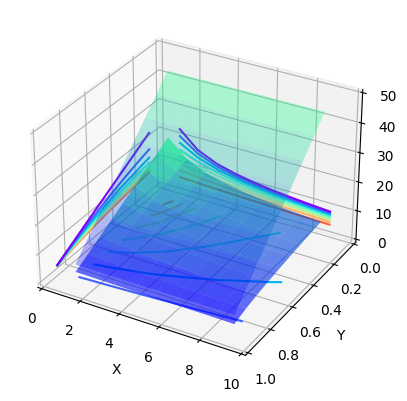

In [18]:
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig4 = plt.figure()
ax4 = plt.axes(projection='3d')

xx = np.arange(1,10,1)
yy = np.arange(0.1,1,0.1)
X, Y = np.meshgrid(xx, yy)
Z1 = MSE_arr_1
Z3 = MSE_arr_3

ax4.plot_surface(X,Y,Z1,alpha=0.3,cmap='winter')
# ax4.contour(X,Y,Z1,zdir='z', offset=0,cmap="rainbow")
# ax4.contour(X,Y,Z1,zdir='x', offset=0,cmap="rainbow")
# ax4.contour(X,Y,Z1,zdir='y', offset=0,cmap="rainbow")
# ax4.contourf(X,Y,Z,zdir='y', offset=0,cmap="rainbow")
ax4.plot_surface(X,Y,Z3,alpha=0.6,cmap='winter')
ax4.contour(X,Y,Z3,zdir='z', offset=0,cmap="rainbow")
ax4.contour(X,Y,Z3,zdir='x', offset=0,cmap="rainbow")
ax4.contour(X,Y,Z3,zdir='y', offset=0,cmap="rainbow")

ax4.set_xlabel('X')
ax4.set_xlim(0, 10)
ax4.set_ylabel('Y')
ax4.set_ylim(1, 0)
ax4.set_zlabel('Z')
ax4.set_zlim(0, 50)

plt.show()
